# Создание модели

Модель сначала сжимает входные значения через Linear, затем LSTM извлекает последовательные зависимости. <br>
Attention позволяет выбрать наиболее значимые участки этой памяти. Маска позволяет игнорировать паддинги. <br>
В результате модель агрегирует информацию в контекстный вектор и делает регрессионное предсказание следующего значения <br>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim, 1)

    def forward(self, encoder_outputs, mask=None):
        # encoder outputs: (batch_size, seq_len, hidden_dim)
        attn_scores = self.attn(encoder_outputs).squeeze(-1)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, float('-inf'))

        attn_weights = F.softmax(attn_scores, dim=-1)  # (batch_size, seq_len)
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs).squeeze(1)  # (batch_size, hidden_dim)
        return context, attn_weights


class LSTMWithAttention(nn.Module):
    def __init__(self, input_dim: int = 1, hidden_dim: int = 64, num_layers: int = 1, dropout: float = 0.1):
        super().__init__()
        self.input_linear = nn.Linear(input_dim, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim,
                            num_layers=num_layers, batch_first=True,
                            dropout=dropout if num_layers > 1 else 0.0)
        self.attention = Attention(hidden_dim)
        self.output_linear = nn.Linear(hidden_dim, 1)

    def forward(self, x: torch.Tensor, mask: torch.Tensor = None) -> torch.Tensor:
        # x: (batch_size, seq_len)
        x = x.unsqueeze(-1)  # (batch_size, seq_len, 1)
        x = self.input_linear(x)  # (batch_size, seq_len, hidden_dim)

        lstm_out, _ = self.lstm(x)  # (batch_size, seq_len, hidden_dim)

        context, attn_weights = self.attention(lstm_out, mask)
        output = self.output_linear(context)

        return output, attn_weights

### Визуализация модели


(process:46320): Pango-WARNING **: 03:22:45.451: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


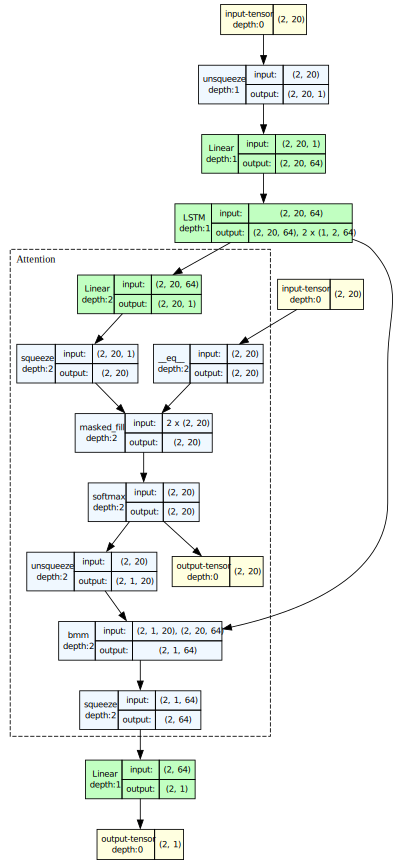

In [2]:
import torch
from torchview import draw_graph

# Параметры модели
input_dim = 1
hidden_dim = 64
seq_len = 20
batch_size = 2

x = torch.randn(batch_size, seq_len)
mask = torch.ones(batch_size, seq_len).bool()

# Инициализация модели
model = LSTMWithAttention(input_dim=input_dim, hidden_dim=hidden_dim)

draw_graph(model, input_data=(x, mask), expand_nested=True).visual_graph

# Генерация данных


In [3]:
import torch
import torch.nn.functional as F
import numpy as np

def generate_linear_sequence(length, a, noise_std=0.0):
    x = np.random.uniform(1, 10)
    sequence = [x]
    for _ in range(length - 1):
        x = x + a + np.random.normal(0, noise_std)
        sequence.append(x)
    return torch.tensor(sequence, dtype=torch.float32)

def generate_logarithmic_sequence(length, a, b, c, noise_std=0.0):
    x = np.random.uniform(1, 10)
    sequence = [x]
    for _ in range(length - 1):
        x = a * np.log(x + b) + c + np.random.normal(0, noise_std)
        sequence.append(x)
    return torch.tensor(sequence, dtype=torch.float32)

def generate_sinusoidal_sequence(length, A, omega, phi, noise_std=0.0):
    x = np.linspace(0, 2 * np.pi, length)
    sequence = A * np.sin(omega * x + phi) + np.random.normal(0, noise_std, size=length)
    return torch.tensor(sequence, dtype=torch.float32)

def generate_mixed_sequence(length, noise_std=0.0):
    half = length // 2
    seq1 = generate_linear_sequence(half, a=2, noise_std=noise_std)
    seq2 = generate_sinusoidal_sequence(length - half, A=1.5, omega=1.0, phi=0, noise_std=noise_std)
    return torch.cat((seq1, seq2))

def generate_dataset(num_samples, max_length=20):
    data = []
    labels = []
    masks = []

    for _ in range(num_samples):
        seq_type = np.random.choice(['linear', 'logarithmic', 'sinusoidal', 'mixed'])
        noise_std = np.random.uniform(0.0, 0.3)
        seq_len = np.random.randint(5, max_length + 1)

        if seq_type == 'linear':
            sequence = generate_linear_sequence(seq_len + 1, a=np.random.uniform(0.5, 2.0), noise_std=noise_std)
        elif seq_type == 'logarithmic':
            sequence = generate_logarithmic_sequence(seq_len + 1, a=np.random.uniform(0.5, 1.5), b=1.0, c=0.5, noise_std=noise_std)
        elif seq_type == 'sinusoidal':
            sequence = generate_sinusoidal_sequence(seq_len + 1, A=2.0, omega=np.random.uniform(0.5, 2.0), phi=np.random.uniform(0, np.pi), noise_std=noise_std)
        else:
            sequence = generate_mixed_sequence(seq_len + 1, noise_std=noise_std)

        x = sequence[:-1]  # вход
        y = sequence[-1]   # целевое значение
        padding = max_length - seq_len

        padded_x = F.pad(x, (0, padding), value=0.0)
        mask = torch.tensor([1] * seq_len + [0] * padding, dtype=torch.bool)

        data.append(padded_x)
        labels.append(y)
        masks.append(mask)

    return torch.stack(data), torch.stack(labels), torch.stack(masks)

In [4]:
torch.manual_seed(42)
np.random.seed(42)
data, labels, masks = generate_dataset(num_samples=100_000)  # or 10_000
print("Data shape:", data.shape)     # (10000, 20)
print("Labels shape:", labels.shape) # (10000,)
print("Masks shape:", masks.shape)   # (10000, 20)

Data shape: torch.Size([100000, 20])
Labels shape: torch.Size([100000])
Masks shape: torch.Size([100000, 20])


In [5]:
from torch.utils.data import Dataset

class SequenceDataset(Dataset):
    def __init__(self, data, labels, masks):
        self.data = data
        self.labels = labels
        self.masks = masks

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.masks[idx], self.labels[idx]

In [6]:
from torch.utils.data import DataLoader, random_split

dataset = SequenceDataset(data, labels, masks)

train_size = int(0.8 * len(dataset))
val_size   = int(0.1 * len(dataset))
test_size  = len(dataset) - train_size - val_size

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

batch_size = 64

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_set, batch_size=batch_size)
test_loader  = DataLoader(test_set, batch_size=batch_size)

In [7]:
next(iter(train_loader))

[tensor([[ 1.6647,  1.2768,  0.4725,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.4284,  0.5311, -0.4737,  ...,  0.0000,  0.0000,  0.0000],
         [ 4.2948,  6.3215,  8.2090,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 7.3229,  9.3399, 11.1841,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.6919,  0.8588, -1.0191,  ...,  0.0000,  0.0000,  0.0000],
         [ 2.6224,  4.5712,  6.1278,  ...,  0.0000,  0.0000,  0.0000]]),
 tensor([[ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False],
         ...,
         [ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False]]),
 tensor([ 1.1577e+00, -7.4836e-01,  1.9015e+01, -2.6930e-01, -6.6016e-01,
          9.7425e-01,  2.5030e+01, -1.3907e-01,  5.2215e-02,  1.4946e+00,
         -4.3866e-02, -2.6811e-02,  3.66

# Обучение

In [8]:
import torch
import torch.nn as nn
from tqdm import tqdm

def train_model(model, train_loader, val_loader, *,
                epochs=100, patience=10, lr=1e-3,
                device='cuda' if torch.cuda.is_available() else 'cpu'):

    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    best_val_loss = float('inf')
    best_state = None
    early_stopping_counter = 0

    train_losses = []
    val_losses = []

    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0.0

        for x, mask, y in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}", leave=False):
            x, mask, y = x.to(device), mask.to(device), y.to(device)
            optimizer.zero_grad()

            output, _ = model(x, mask)
            loss = criterion(output.squeeze(), y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * x.size(0)

        train_loss /= len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x, mask, y in val_loader:
                x, mask, y = x.to(device), mask.to(device), y.to(device)
                output, _ = model(x, mask)
                loss = criterion(output.squeeze(), y)
                val_loss += loss.item() * x.size(0)

        val_loss /= len(val_loader.dataset)

        print(f"Epoch {epoch} — Train Loss: {train_loss:.4f} — Val Loss: {val_loss:.4f}")
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = model.state_dict()
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print(f"\nEarly stopping triggered after {epoch} epochs.")
                break

    # Load best weights
    if best_state:
        model.load_state_dict(best_state)

    return model, train_losses, val_losses

In [9]:
print(torch.cuda.is_available())

# Обучение
trained_model = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=200,
    patience=15,
    lr=1e-3,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

True


Epoch 1 — Train Loss: 15.9984 — Val Loss: 1.4963


Epoch 2 — Train Loss: 0.5871 — Val Loss: 0.2518


Epoch 3 — Train Loss: 0.2435 — Val Loss: 0.1663


Epoch 4 — Train Loss: 0.1346 — Val Loss: 0.1238


Epoch 5 — Train Loss: 0.1105 — Val Loss: 0.0821


Epoch 6 — Train Loss: 0.1039 — Val Loss: 0.1460


Epoch 7 — Train Loss: 0.0795 — Val Loss: 0.0891


Epoch 8 — Train Loss: 0.0697 — Val Loss: 0.0770


Epoch 9 — Train Loss: 0.0687 — Val Loss: 0.0844


Epoch 10 — Train Loss: 0.0796 — Val Loss: 0.0553


Epoch 11 — Train Loss: 0.0673 — Val Loss: 0.0597


Epoch 12 — Train Loss: 0.0615 — Val Loss: 0.0931


Epoch 13 — Train Loss: 0.0658 — Val Loss: 0.0484


Epoch 14 — Train Loss: 0.0628 — Val Loss: 0.0521


Epoch 15 — Train Loss: 0.0568 — Val Loss: 0.0520


Epoch 16 — Train Loss: 0.0570 — Val Loss: 0.0464


Epoch 17 — Train Loss: 0.0571 — Val Loss: 0.0565


Epoch 18 — Train Loss: 0.0596 — Val Loss: 0.0516


Epoch 19 — Train Loss: 0.0533 — Val Loss: 0.0588


Epoch 20 — Train Loss: 0.0571 — Val Loss: 0.0644


Epoch 21 — Train Loss: 0.0539 — Val Loss: 0.0446


Epoch 22 — Train Loss: 0.0522 — Val Loss: 0.0572


Epoch 23 — Train Loss: 0.0521 — Val Loss: 0.0466


Epoch 24 — Train Loss: 0.0511 — Val Loss: 0.0611


Epoch 25 — Train Loss: 0.0515 — Val Loss: 0.0565


Epoch 26 — Train Loss: 0.0491 — Val Loss: 0.0529


Epoch 27 — Train Loss: 0.0502 — Val Loss: 0.0535


Epoch 28 — Train Loss: 0.0496 — Val Loss: 0.0441


Epoch 29 — Train Loss: 0.0493 — Val Loss: 0.0443


Epoch 30 — Train Loss: 0.0483 — Val Loss: 0.0448


Epoch 31 — Train Loss: 0.0476 — Val Loss: 0.0431


Epoch 32 — Train Loss: 0.0473 — Val Loss: 0.0482


Epoch 33 — Train Loss: 0.0468 — Val Loss: 0.0546


Epoch 34 — Train Loss: 0.0474 — Val Loss: 0.0708


Epoch 35 — Train Loss: 0.0466 — Val Loss: 0.0442


Epoch 36 — Train Loss: 0.0461 — Val Loss: 0.0467


Epoch 37 — Train Loss: 0.0471 — Val Loss: 0.0465


Epoch 38 — Train Loss: 0.0456 — Val Loss: 0.0488


Epoch 39 — Train Loss: 0.0461 — Val Loss: 0.0459


Epoch 40 — Train Loss: 0.0453 — Val Loss: 0.0460


Epoch 41 — Train Loss: 0.0444 — Val Loss: 0.0443


Epoch 42 — Train Loss: 0.0447 — Val Loss: 0.0424


Epoch 43 — Train Loss: 0.0453 — Val Loss: 0.0499


Epoch 44 — Train Loss: 0.0448 — Val Loss: 0.0430


Epoch 45 — Train Loss: 0.0438 — Val Loss: 0.0406


Epoch 46 — Train Loss: 0.0443 — Val Loss: 0.0412


Epoch 47 — Train Loss: 0.0444 — Val Loss: 0.0450


Epoch 48 — Train Loss: 0.0431 — Val Loss: 0.0509


Epoch 49 — Train Loss: 0.0432 — Val Loss: 0.0426


Epoch 50 — Train Loss: 0.0432 — Val Loss: 0.0475


Epoch 51 — Train Loss: 0.0433 — Val Loss: 0.0420


Epoch 52 — Train Loss: 0.0424 — Val Loss: 0.0437


Epoch 53 — Train Loss: 0.0428 — Val Loss: 0.0442


Epoch 54 — Train Loss: 0.0432 — Val Loss: 0.0399


Epoch 55 — Train Loss: 0.0421 — Val Loss: 0.0447


Epoch 56 — Train Loss: 0.0417 — Val Loss: 0.0415


Epoch 57 — Train Loss: 0.0420 — Val Loss: 0.0424


Epoch 58 — Train Loss: 0.0418 — Val Loss: 0.0480


Epoch 59 — Train Loss: 0.0417 — Val Loss: 0.0409


Epoch 60 — Train Loss: 0.0417 — Val Loss: 0.0516


Epoch 61 — Train Loss: 0.0419 — Val Loss: 0.0427


Epoch 62 — Train Loss: 0.0415 — Val Loss: 0.0424


Epoch 63 — Train Loss: 0.0412 — Val Loss: 0.0432


Epoch 64 — Train Loss: 0.0413 — Val Loss: 0.0404


Epoch 65 — Train Loss: 0.0411 — Val Loss: 0.0414


Epoch 66 — Train Loss: 0.0407 — Val Loss: 0.0423


Epoch 67 — Train Loss: 0.0416 — Val Loss: 0.0408


Epoch 68 — Train Loss: 0.0409 — Val Loss: 0.0412


Epoch 69 — Train Loss: 0.0412 — Val Loss: 0.0426

Early stopping triggered after 69 epochs.


### Save model

In [19]:
torch.save(trained_model.state_dict(), "lstm_with_attention_best_weights.pt")
torch.save(trained_model, "lstm_with_attention_full.pt")
print("Model saved ✅")

Model saved ✅


In [20]:
torch.save(trained_model.state_dict(), "weights/lstm_epoch69_val040.pt")
torch.save(trained_model, "saved_models/lstm_full.pt")
print("Model saved ✅")

Model saved ✅


# Тестирование

In [10]:
import matplotlib.pyplot as plt

def test_model(model, test_loader, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.eval()
    model.to(device)

    total_loss = 0.0
    criterion = torch.nn.MSELoss()
    predictions = []
    targets = []
    all_attn_weights = []

    with torch.no_grad():
        for x, mask, y in test_loader:
            x, mask, y = x.to(device), mask.to(device), y.to(device)
            output, attn_weights = model(x, mask)
            loss = criterion(output.squeeze(), y)
            total_loss += loss.item() * x.size(0)

            predictions.extend(output.squeeze().cpu().numpy())
            targets.extend(y.cpu().numpy())
            all_attn_weights.extend(attn_weights.cpu().numpy())

    avg_loss = total_loss / len(test_loader.dataset)
    print(f"\nTest MSE: {avg_loss:.4f}")
    return predictions, targets, all_attn_weights


def plot_loss_curves(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def visualize_attention(attn_weights, sequence, mask=None, idx=0):
    weights = attn_weights[idx]
    values = sequence[idx].cpu().numpy()
    if mask is not None:
        weights = weights * mask[idx].cpu().numpy()

    plt.figure(figsize=(10, 2))
    plt.bar(range(len(weights)), weights, alpha=0.6)
    plt.title("Attention Weights")
    plt.xlabel("Time Step")
    plt.ylabel("Weight")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print("Sequence Values:")
    print(values)
    print("\nAttention:")
    print(weights)

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

preds, targs, _ = test_model(trained_model, test_loader)

mse = mean_squared_error(targs, preds)
mae = mean_absolute_error(targs, preds)

print(f"Test MSE: {mse:.4f} — MAE: {mae:.4f}")


Test MSE: 0.0420
Test MSE: 0.0420 — MAE: 0.1469



Test MSE: 0.0420


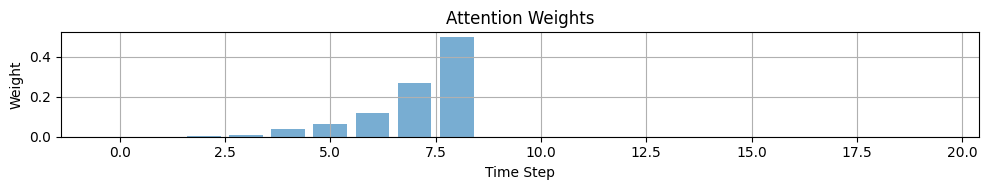

Sequence Values:
[ 1.8487469   1.2813705   0.7824702  -0.45425543 -1.6186118  -1.8345762
 -1.9968965  -1.4048029  -0.2901533   0.2352941   1.1318513   1.8399818
  1.6239886   1.3237003   0.07357122 -1.0842528  -1.230119   -2.0367498
 -1.8281635   0.        ]

Attention:
[2.2301372e-06 5.5789016e-05 1.3070621e-03 9.9203130e-03 3.8226452e-02
 6.3961670e-02 1.1659372e-01 2.7136937e-01 4.9856338e-01 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]


In [12]:
preds, targs, attns = test_model(trained_model, test_loader)
# plot_loss_curves(train_loss_list, val_loss_list)
visualize_attention(attns, data, masks, idx=0)

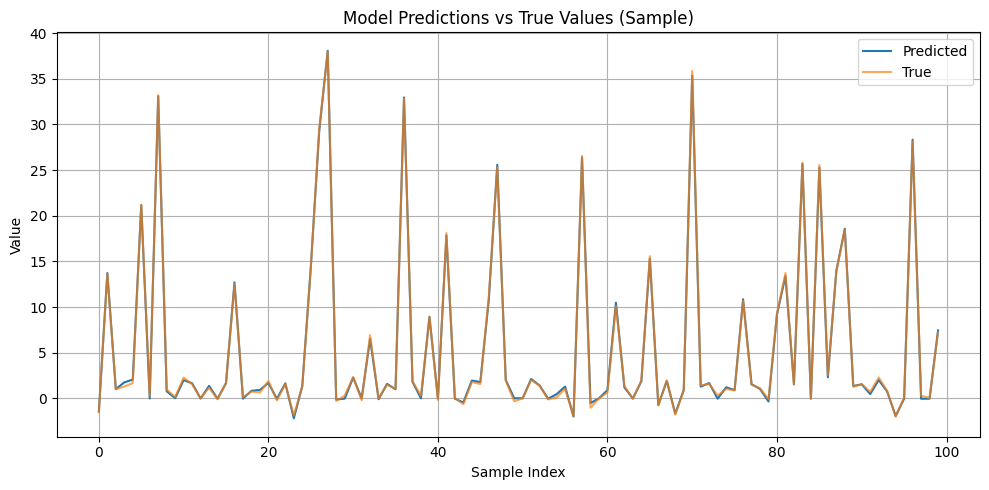

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(preds[:100], label='Predicted')
plt.plot(targs[:100], label='True', alpha=0.7)
plt.title('Model Predictions vs True Values (Sample)')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


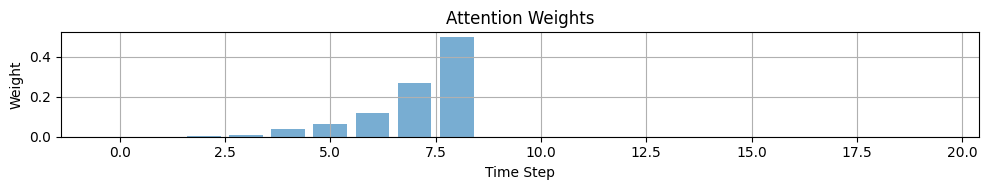

Sequence Values:
[ 1.7479955   1.2694786   0.6255953  -0.10599504 -0.8285719  -1.4291316
 -1.8394464  -1.9945188  -1.883508    0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]

Attention:
[2.2301372e-06 5.5789016e-05 1.3070621e-03 9.9203130e-03 3.8226452e-02
 6.3961670e-02 1.1659372e-01 2.7136937e-01 4.9856338e-01 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]


In [14]:
# Используем исходные данные и маску из датасета
test_batch = next(iter(test_loader))
x_batch, mask_batch, y_batch = test_batch

# Показываем attention и последовательность
visualize_attention(attns, x_batch, mask_batch, idx=0)

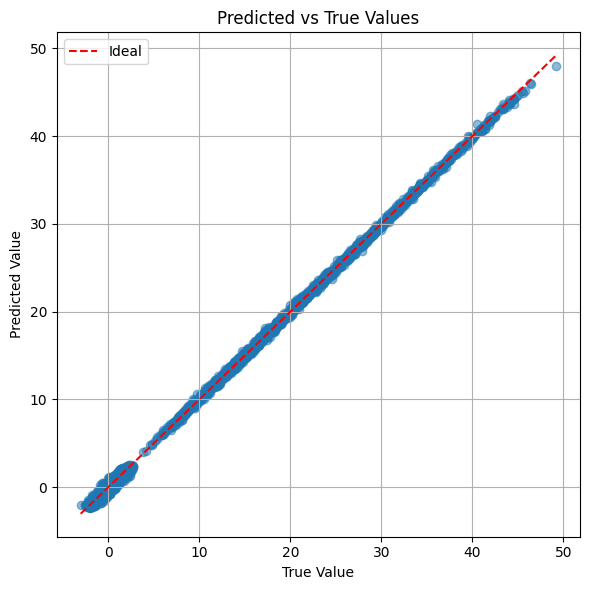

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(targs, preds, alpha=0.5)
plt.plot([min(targs), max(targs)], [min(targs), max(targs)], 'r--', label='Ideal')
plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.title('Predicted vs True Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


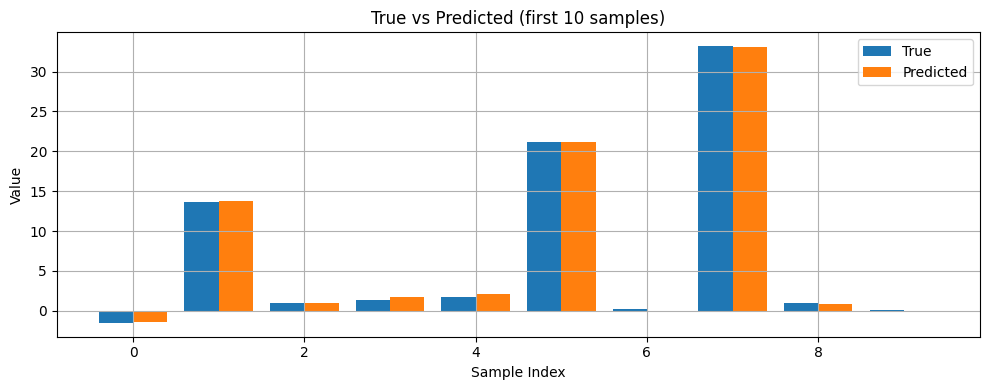

In [16]:
import numpy as np

N = 10  # первые 10 примеров
x = np.arange(N)

plt.figure(figsize=(10, 4))
plt.bar(x - 0.2, [targs[i] for i in x], width=0.4, label='True')
plt.bar(x + 0.2, [preds[i] for i in x], width=0.4, label='Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('True vs Predicted (first 10 samples)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\alex0\AppData\Local\Temp\ipykernel_33088\2380901263.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=np.arange(len(values)), y=weights, palette='coolwarm', alpha=0.6)


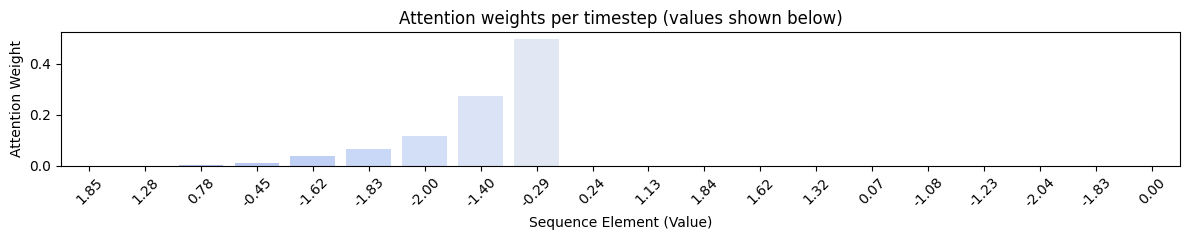

In [17]:
def visualize_attention_bars(attn_weights, input_sequence, mask=None, idx=0):
    import matplotlib.pyplot as plt
    import seaborn as sns

    weights = attn_weights[idx]
    values = input_sequence[idx].cpu().numpy()
    if mask is not None:
        weights = weights * mask[idx].cpu().numpy()

    plt.figure(figsize=(12, 2.5))
    sns.barplot(x=np.arange(len(values)), y=weights, palette='coolwarm', alpha=0.6)
    plt.xticks(ticks=np.arange(len(values)), labels=[f'{v:.2f}' for v in values], rotation=45)
    plt.title("Attention weights per timestep (values shown below)")
    plt.xlabel("Sequence Element (Value)")
    plt.ylabel("Attention Weight")
    plt.tight_layout()
    plt.show()

visualize_attention_bars(attns, data, masks, idx=0)